# Entrenando un agente

## El agente en acción

Asumamos que nuestro agente tiene un número limitado de acciones posibles:

$$
\mathcal{A} = \{a_1, a_2, a_3, \ldots, a_N\}
$$

En cada instante $t$ el agente escoge una acción en base al estado. La decisión se hace según una función denominada **política** (*policy*) que mapea el espacio de estados al espacio de acciones. La política puede ser de tipo:

**Determinista:** La política está representada por una función 

$$
a  = \pi (s)
$$

Ej: Si tengo hambre y el timbre no está sonando apreto el timbre

**Estocástica:** La política está representada por probabilidades

$$
a \sim \pi(A|S) = P(A=a|S=s)
$$

Ej: Si tengo hambre y el timbre no está sonando

- 9 de 10 veces apreto el timbre
- 1 de 10 veces aparece una mosca que me distrae y lo dejo en paz

En promedio apreto el timbre un 90% de las veces que me da hambre.

Veamos a continuación como podemos definir una **política óptima**. Asumamos que estamos en un instante $t$ en particular. Podemos definir la **recompensa total futura** como

$$
R_t + R_{t+1} + R_{t+2} + R_{t+3} +\ldots 
$$

y diseñar una política para maximizarla, pero:

- Problema 1: La recompensa total futura podría diverger
- Problema 2: Los ambientes son no estacionarios y existe incerteza sobre el futuro

Matemáticamente, es más razonable usar una **recompensa total futura descontada**

$$
\begin{split}
G_t &= R_t + \gamma R_{t+1} + \gamma^2 R_{t+2} + \ldots  \\
& = \sum_{k=0}^\infty \gamma^k R_{t+k} 
\end{split}
$$

donde $\gamma \approx 0.99$ es el factor de descuento, que controla la escala de tiempo del aprendizaje del agente.

## Función Q

En base a $G_t$ podemos escribir la **recompensa total futura esperada** o **ganancia esperada**

$$
Q(s,a) = \mathbb{E}[G_t|S_t=s, A_t=a] 
$$

también llamada función **Q**. La función Q nos dice cuanta recompensa futura podemos obtener si estamos en el estado $s$ y ejecutamos la acción $a$. 

Luego una  política determinista basada en Q podría ser:

$$
\pi^*(s) = \text{arg} \max_{a\in \mathcal{A}} Q(s, a)
$$

que se basa en el:

> **Principio de máximas utilidades**: Un agente racional escogerá la acción que maximize su ganancia esperada


Si conocemos la función de transición del ambiente podemos descomponer la función **Q** como sigue

$$
\begin{split}
Q(s,a) &= \mathbb{E}[G_t|S_t=s, A_t=a]  \\
&= R(s,a) + \gamma  \sum_{s' \in \mathcal{S}} T(s, a, s') \max_{a' \in \mathcal{A}} Q(s', a') 
\end{split}
$$

que se conoce como **Ecuación de Bellman**.

Si el ambiente es determinista y la acción $a$ en $s$ me lleva a $s'$ entonces lo anterior se simplifica a

$$
Q(s,a) = R(s,a) + \gamma  \max_{a' \in \mathcal{A}} Q(s', a')
$$

Es decir que el valor Q en el estado actual es igual a la recompensa percibida actualmente más el valor descontado del mejor Q alcanzanble en el nuevo estado. A continuación se explica formalmente el algoritmo de Q-learning.


## Q-Learning

Sea un agente con un conjunto finito de acciones y un ambiente con un conjunto finito de estados. La función Q se representa como una tabla. Por ejemplo si tenemos tres estados y dos acciones:

```{list-table}
:header-rows: 1

* -
  - $a_1$
  - $a_2$
* - $s_1$
  - $0$
  - $0$
* - $s_2$
  - $0$
  - $0$
* - $s_3$
  - $0$
  - $0$
```

La tabla Q está inicialmente llena de ceros. El entrenamiento del agente consiste en llenar la tabla mediante prueba y error. 

En cada prueba el agente, que está en un estado $s$, realiza una acción $a$, obtiene una recompensa $R(s,a)$ y avanza al estado $s'$. El algoritmo de Q-learning usa la siguiente regla de actualización:

$$
\begin{split}
Q(s, a) &\leftarrow & (1-\alpha)Q(s,a) + \alpha \left(R(s,a) + \gamma \max_{a' \in \mathcal{A}} Q(s', a')\right)  =  \\
&& Q(s,a) + \alpha \left(R(s,a) + \gamma \max_{a' \in \mathcal{A}} Q(s', a') - Q(s,a)\right)
\end{split}
$$

donde $\alpha \in [0, 1]$ es la tasa de aprendizaje.

La intuición es que si:

- realizamos una acción en un estado determinado y nos da un resultado no deseado: evitar esa acción en ese estado
- realizamos una acción en un estado determinado y nos da un resultado deseado: preferir esa acción en ese estado
- todas las acciones en un cierto estado producen un resultado no deseado: evitar ese estado
- todas las acciones en un cierto estado producen un resultado deseado: buscar ese estado

## Nuestro primer agente en Python

Con lo visto hasta ahora tenemos lo necesario para entrenar nuestro primer agente de RL.

Para simular el ambiente y el agente utilizaremos el *toolkit* [gymnasium](https://github.com/Farama-Foundation/Gymnasium). La documentación completa se puede revisar en: https://gymnasium.farama.org/.

Para instalar

    pip install "gymnasium[atari]" pygame --default-timeout=1000

Esto instalará los ambientes por defecto y adicionalmente los ambientes basados en juegos de ATARI.

### Creando un ambiente

Utilizaremos como ejemplo el ambiente de [La laguna congelada](https://gymnasium.farama.org/environments/toy_text/frozen_lake/#frozen-lake).

> "Usted y sus amigos juegan a lanzar el frisbee. El frisbee cae en una laguna que está parcialmente congelada. El objetivo es recuperar el frisbee sin caer donde se ha derretido el hielo"

Con  esta premisa veamos como cargar este ambiente en *gym*

In [1]:
import gymnasium as gym

# Genera el ambiente
env = gym.make("FrozenLake-v1", render_mode="ansi")

# Resetea el ambiente
env.reset()

# Muestra el ambiente
print(env.render())


SFFF
FHFH
FFFH
HFFG



El argumento `render_mode="ansi"` retorna el ambiente como un string. El ambiente por defecto tiene 4x4 = 16 espacios que representan la laguna congelada:

- F (Frozen), es seguro caminar por ese bloque
- H (Hole), te ahogas y mueres
- S (Start), la posición inicial del agente
- G (Goal), la posición del frisbee

También podemos utilizar `render_mode="rgb_array"` para obtener el ambiente como una colección de píxeles o la opción `human` para mostrar el ambiente en una ventana independiente.

In [2]:
env = gym.make("FrozenLake-v1", render_mode="rgb_array")
env.reset()
image = env.render()

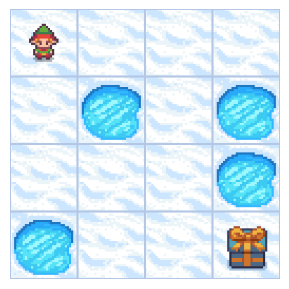

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt

def plot_frame(frame):
    fig, ax = plt.subplots(figsize=(4, 3), tight_layout=True)
    ax.imshow(frame)
    ax.axis('off')

plot_frame(image)

:::{note}

En este ambiente se tiene completa observabilidad de los estados.

:::

Se puede consultar directamente sobre el tamaño del espacio de estados y estado actual con:

In [4]:
# Espacio de estados
display(env.observation_space)
display(env.observation_space.n)

# Estado actual
display(env.s)

Discrete(16)

16

0

Podemos consultar el tamaño del espacio de acciones con:

In [5]:
# Espacio de acciones
display(env.action_space, env.action_space.n)

Discrete(4)

4

Las acciones son: 

- 0: LEFT
- 1: DOWN
- 2: RIGHT
- 3: UP

Además debemos considerar que en este ambiente:

- El agente rebota en las paredes
- El hielo es resbaladizo: **Las acciones tienen un componente estocástico**

Podemos muestrear una acción aleatoria con la propiedad `sample`

In [6]:
for k in range(10):
    print(f"{k}: {env.action_space.sample()}")

0: 3
1: 1
2: 1
3: 1
4: 2
5: 0
6: 0
7: 3
8: 1
9: 1


La distribución de la acción aleatoria es uniforme

In [7]:
from collections import Counter

actions = [env.action_space.sample() for k in range(10_000)]
Counter(actions)

Counter({3: 2613, 2: 2513, 1: 2452, 0: 2422})

### Actuando en el ambiente

Podemos ejecutar una acción sobre el ambiente con la función `step`. Esta función retorna el nuevo estado al que llegamos y la recompensa .

Recordemos este escenario es **estocástico**: La acción que ejecutamos no es siempre la que efectivamente se realiza.

Estoy en el estado: 0
Selecciono la acción 3
Llegué al estado: 0 y obtuve la recompensa: 0.0


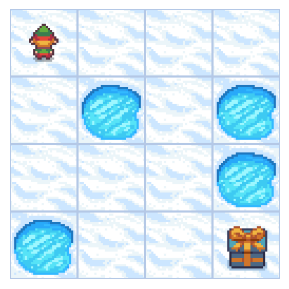

In [8]:
env.reset()
env.render()

print(f"Estoy en el estado: {env.s}")

a = env.action_space.sample()
print(f"Selecciono la acción {a}")

s, r, terminated, truncated, info = env.step(a)
print(f"Llegué al estado: {s} y obtuve la recompensa: {r}")

image =  env.render()
plot_frame(image)

Por ejemplo la distribución para moverme a la izquierda desde el cuadro inicial es

In [9]:
env.reset()

arrival_state = []
for k in range(10_000):
    env.reset()
    s, r, terminated, truncated, info = env.step(0)
    arrival_state.append(s)

Counter(arrival_state)

Counter({0: 6628, 4: 3372})

Es decir que:

- En 2/3 de los casos reboto en la pared y me quedo donde estoy
- En 1/3 de los casos me muevo hacia abajo y llego a 4

Esto también estaba indicado en `info`

In [10]:
info

{'prob': 0.3333333333333333}

**Recompensa y condición de término**

Existen tres condiciones de término del "episodio" (fin del juego)

- Llegar al objetivo: recompensa +1
- Caer en un agujero: recompensa +0
- Realizar 100 pasos: recompesa +0

¿Cómo le irá a un agente con politica aleatoria?

In [11]:
from IPython.display import clear_output
from time import sleep

env = gym.make("FrozenLake-v1", render_mode="ansi")
env.reset()
step, terminated = 0, False

while not terminated:
    a = env.action_space.sample()
    s, r, terminated, truncated, info = env.step(a)
    clear_output(wait=True)
    print(f"Paso {step}, Recompensa: {r}")
    print(env.render())    
    sleep(.25)
    step += 1

Paso 9, Recompensa: 0.0
  (Down)
SFFF
FHFH
FFFH
HFFG



(La animación no se reproduce en la versión web de este cuadernillo)

## Entrenamiento con Q-Learning

Entrenemos nuestro agente usando una tabla de Q-Learning inicialmente en cero. En cada iteración la actualizamos la tabla con:

$$
Q(s,a) \leftarrow Q(s,a) + \alpha \left(R(s,a) + \gamma \max_{a' \in \mathcal{A}} Q(s', a') - Q(s,a)\right)
$$

Como el ambiente es estocástico es preferible una tasa de aprendizaje baja. Estudiemos lo que ocurre:

In [12]:
import numpy as np

env = gym.make("FrozenLake-v1", render_mode="ansi")
rewards = []
alpha, gamma = 0.1, 0.9
Q = np.zeros(shape=(env.observation_space.n, env.action_space.n))

for episode in range(10):
    env.reset()    
    terminated = False    
    while not terminated:  
        s_current = env.s
        # Escoger la mejor acción
        a = np.argmax(Q[s_current, :]) 
        # Ejecutarla
        s_future, r, terminated, truncated, info = env.step(a)
        # Actualizar Q
        Q[s_current, a] += alpha*(r + gamma*np.max(Q[s_future, :]) - Q[s_current, a])
    rewards.append(r)

Revisemos la tabla Q y las recompensas ganadas:

In [13]:
display(Q, Counter(rewards))

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

Counter({0.0: 10})

¿Por qué ocurrió esto? El problema está en la siguiente línea de código:

```python
    a = np.argmax(Q[s_current, :]) 
```


### Dilema de exploración y explotación: Epsilon-Greedy Q-Learning

Un problema del algoritmo Q-Learning es que es demasiado explotador.

> Siempre escoge la acción que maximiza **Q**: es una *greedy policy*.

Sin embargo, y especialmente al inicio, es crítico explorar el espacio de acciones. Se puede hacer la siguiente corrección:

Se muestrea una variable Bernoulli (binaria) con probabilidad $1-\epsilon$ de ser $1$

- Si resulta 1, entonces se sigue la política óptima (greedy)
- Si resulta 0, entonces se escoge una acción al azar

Típicamente se inicia $\epsilon$ en un valor cercano a $1$ y se hace $\epsilon \to 0$ para $t \to \infty$. Esta estrategia se denomina Epsilon-Greedy.

Los parámetros de Q-Learning convencional son la tasa de aprendizaje $\alpha$, el factor de descuento $\gamma$ y el número de episodios, es decir la cantidad de veces que se presenta el escenario al agente.

A más alto $\alpha$, más rápido se adoptan los cambios en la matriz Q. Sin embargo un valor muy alto puede ser perjudicial si el ambiente es estocástico. Un valor típico es $\alpha = 0.1$

Si $\gamma = 0$ el aprendizaje sólo se enfoca en el presente. Por otro lado si $\gamma = 1$ las recompensas de largo y corto plazo tienen igual valor y se tienen problemas de convergencia. Un valor típico es $\gamma = 0.9$

Ahora hemos agregado $\epsilon$ el cual podemos definir según:

- El valor inicial y final para $\epsilon$ 
- La estrategia de disminución de $\epsilon$

Por ejemplo una estrategia exponencial con tasa de disminución $\tau_\epsilon>0$ sería:

$$
\epsilon_k = \epsilon_T + (\epsilon_0 - \epsilon_T) e^{-\tau_\epsilon k}
$$

donde $\epsilon_0$ debe ser mucho mayor que $\epsilon_T$. Todos estos hiper-parámetros definen la transición entre las fases de exploración y explotación.

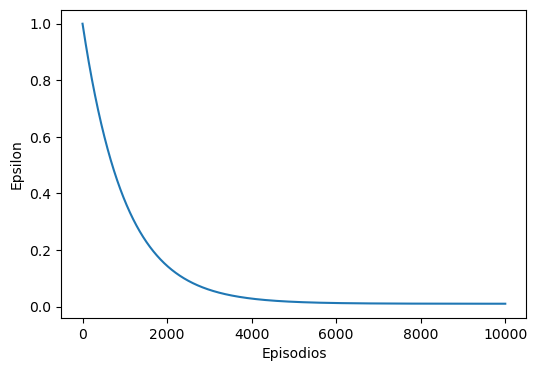

In [14]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 4))

episodes = np.arange(10000)
epsilon_init = 1.0
epsilon_end = 0.01
epsilon_rate = 1e-3
ax.plot(episodes, epsilon_end + (epsilon_init - epsilon_end) * np.exp(-epsilon_rate*episodes));
ax.set_xlabel('Episodios')
ax.set_ylabel('Epsilon');

Entrenemos nuevamente en el ambiente de alguna congelada con Epsilon-Greedy Q-Learning

In [15]:
%%time

env = gym.make("FrozenLake-v1", render_mode="ansi")
Q = np.zeros(shape=(env.observation_space.n, env.action_space.n))
diagnostics = {'rewards': [], 'episode_length': []}
# Hiper-parámetros
alpha, gamma, n_episodios = 0.1, 0.99, 10_000
epsilon_init, epsilon_end, epsilon_rate = 1.0, 0.01, 1e-3 
epsilon = lambda episode : epsilon_end + (epsilon_init - epsilon_end) * np.exp(-epsilon_rate*episode) 
n_evaluations = 100

for episode in range(n_episodios):
    env.reset()
    terminated = False
    while not terminated:        
        s_current = env.s
        # Seleccionar la acción con política Epsilon-Greedy
        if not np.random.binomial(1, p=1.-epsilon(episode)) and ~np.all(Q[s_current, :]==0): 
            a = np.argmax(Q[s_current, :])  
        else:
            a = env.action_space.sample() 
        s_future, r, terminated, truncated, info = env.step(a)
        Q[s_current, a] += alpha*(r + gamma*np.max(Q[s_future, :]) - Q[s_current, a]) 

    # Cada 100 episodios evaluamos el agente sin Epsilon-Greedy:
    if np.mod(episode, 100) == 0:
        diagnostics['rewards'].append(np.zeros(shape=(n_evaluations,)))
        diagnostics['episode_length'].append(np.zeros(shape=(n_evaluations,)))
        for k in range(n_evaluations):
            env.reset()    
            terminated = False
            episode_length, episode_reward = 0, 0.0            
            while not terminated:        
                s_current = env.s
                if not np.all(Q[s_current, :]==0): 
                    a = np.argmax(Q[s_current, :])  
                else:
                    a = env.action_space.sample() 
                s_future, r, terminated, truncated, info = env.step(a)
                episode_length += 1
                episode_reward += r            
            diagnostics['rewards'][-1][k] = episode_reward
            diagnostics['episode_length'][-1][k] = episode_length

CPU times: user 22.2 s, sys: 2.8 s, total: 25 s
Wall time: 22 s


### Diagnósticos: Debuggeando lo aprendido


El aprendizaje se puede diagnosticar observando gráficas de la evolución de la recompensa y la cantidad de pasos promedio.

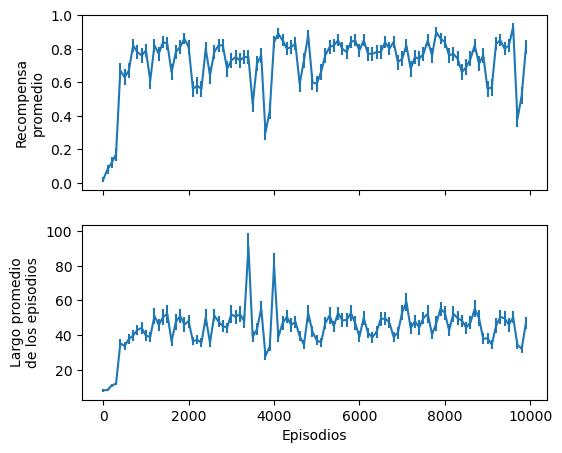

In [16]:
fig, ax = plt.subplots(2, figsize=(6, 5), sharex=True)
ax[0].errorbar(np.arange(10000//100)*100,
               np.array(diagnostics['rewards']).mean(axis=1), 
               np.array(diagnostics['rewards']).std(axis=1)/np.sqrt(n_evaluations));
ax[0].set_ylabel('Recompensa\npromedio');
ax[1].errorbar(np.arange(10000//100)*100,
               np.array(diagnostics['episode_length']).mean(axis=1), 
               np.array(diagnostics['episode_length']).std(axis=1)/np.sqrt(n_evaluations));
ax[1].set_xlabel('Episodios')
ax[1].set_ylabel('Largo promedio\nde los episodios');

> La recompensa y el largo de los episodios aumentan y luego tienden a estabilizarse. 

Se puede verificar el aprendizaje del agente observando la tabla Q 

¿Cuáles estádos acciones/estados tienen recompoensa esperada cero?

In [17]:
np.set_printoptions(precision=3)    
display(Q)
display(np.arange(16).reshape(4, 4))
print(env.render())

array([[0.555, 0.542, 0.542, 0.538],
       [0.33 , 0.379, 0.338, 0.513],
       [0.484, 0.479, 0.477, 0.502],
       [0.359, 0.288, 0.364, 0.487],
       [0.578, 0.426, 0.437, 0.403],
       [0.   , 0.   , 0.   , 0.   ],
       [0.384, 0.188, 0.422, 0.239],
       [0.   , 0.   , 0.   , 0.   ],
       [0.43 , 0.473, 0.319, 0.611],
       [0.348, 0.683, 0.543, 0.515],
       [0.636, 0.583, 0.543, 0.35 ],
       [0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   ],
       [0.557, 0.632, 0.806, 0.569],
       [0.766, 0.904, 0.881, 0.807],
       [0.   , 0.   , 0.   , 0.   ]])

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11],
       [12, 13, 14, 15]])

  (Left)
SFFF
FHFH
FFFH
HFFG



**Probando nuestro agente en vivo**

In [18]:
env.reset()
step, terminated = 0, False

while not terminated:        
    s_current = env.s
    a = np.argmax(Q[s_current, :])  
    s_future, r, terminated, truncated, info = env.step(a)
    clear_output(wait=True)
    print(f"Paso {step}, Recompensa: {r}")
    print(env.render())    
    sleep(.2)
    step += 1

Paso 68, Recompensa: 1.0
  (Down)
SFFF
FHFH
FFFH
HFFG



¿Qué ocurre si el ambiente no es estocástico? Utilice

```python
env = gym.make("FrozenLake-v1", render_mode="ansi", is_slippery=False)
```

para explorar esta situación.